In [1]:
# Main imports
import numpy as np
import pandas as pd

# Import matplotlib and such
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

from scipy import stats
from sklearn.linear_model import LinearRegression

from helper_functions import \
    thermodynamic_model, \
    plot_manifold_model, \
    plot_manifold_measurements

In [2]:
# Set global styles
textwidth=5.5
halfcolwidth=3
fontsize=8
titlesize=10
panel_label_size=12
legend_fontsize=7
markersize=5
mpl.rcParams['font.size'] = fontsize
mpl.rcParams['text.usetex'] = False

# Get default colors
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Used to create color gradient across data points of different P values
color_strong = np.array([.11, .69, .93])
color_weak = np.array([1.00, .94, .21])

# Conversion parameter
kbt_to_kcal = 1/1.62

# Set t_sat, t_bg
log_t_sat = 2.722414412  # FINAL 18.11.08
log_t_bg_occ = -6.074688216 # FINAL 18.11.08

In [3]:
print('t_sat = %.2e'%np.exp(log_t_sat))
print('t_bg = %.2e'%np.exp(log_t_bg_occ))

t_sat = 1.52e+01
t_bg = 2.30e-03


In [4]:
# Load data
data_df = pd.read_excel('../data/results.xlsx', sheet_name='cAMP_summary')

# Create crp_spacing column
data_df['crp_spacing'] = np.nan
for i in data_df.index:
    name = data_df.loc[i,'name']
    if name[:3] == 'oc0':
        data_df.loc[i,'crp_spacing'] = +0.5 

# Show data_df
data_df.head()

,name,location,log_t_250.0,dlog_t_250.0,log_t_125.0,dlog_t_125.0,log_t_50.0,dlog_t_50.0,log_t_25.0,dlog_t_25.0,log_t_10.0,dlog_t_10.0,log_t_5.0,dlog_t_5.0,log_t_2.5,dlog_t_2.5,log_t_0.0,dlog_t_0.0,crp_spacing
0,c71r18.10L01,b2F3,2.104298,0.279520,1.607857,0.145819,1.060987,0.097711,0.630578,0.207070,0.236445,0.075767,-0.954058,0.060818,-1.381149,0.090419,-1.176688,0.297095,NaN
1,c71r18.10L03,b2F5,2.347573,0.328492,1.992565,0.061578,1.708584,0.027214,1.470644,0.066423,1.308100,0.049530,0.649919,0.018370,0.284233,0.042099,0.533403,0.215618,NaN
2,c71r18.10L04,b2F6,-4.515713,1.411395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.639048,0.373580,NaN
3,c71r18.10L05,b2F7,1.741961,0.276959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.262907,0.128559,NaN
4,c71r18.10L06,b2F8,1.830368,0.224218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.230729,0.060900,NaN


In [5]:
# Only keep data where at least 4 concentrations were measured

In [6]:
full = np.array([.80, .48, .93])
none = np.array([1, 1, 1])
concs = [250,125,50,25,10,5,2.5]
colors_dict = {
    250: .66*full,
    125: .80*full,
    50: full,
    25: .80*full + .20*none,
    10: .66*full + .33*none,
    5: .50*full + .50*none,
    2.5: .33*full + .66*none
}

# Create new df that is compatible with plotting tools
new_df = pd.DataFrame(columns=['name','log_t+','log_t-','outlier'])
for i, row in data_df.iterrows():
    for conc in concs:
        new_row_dict = {
            'name':'%.1f_%s'%(conc,row['name']),
            'log_t+':row['log_t_%.1f'%conc],
            'log_t-':row['log_t_0.0'],
            'outlier':False,
            'dlog_t+':0,
            'dlog_t-':0
        }
        new_df = new_df.append(new_row_dict, ignore_index=True)

new_df = new_df.dropna()
new_df = new_df.set_index('name')
new_df.head()

,log_t+,log_t-,outlier,dlog_t+,dlog_t-
name,,,,,
250.0_c71r18.10L01,2.104298,-1.176688,False,0.0,0.0
125.0_c71r18.10L01,1.607857,-1.176688,False,0.0,0.0
50.0_c71r18.10L01,1.060987,-1.176688,False,0.0,0.0
25.0_c71r18.10L01,0.630578,-1.176688,False,0.0,0.0
10.0_c71r18.10L01,0.236445,-1.176688,False,0.0,0.0


In [7]:
# Load fitting results
results_df = pd.DataFrame(columns=['conc','crp_spacing','log_F_50','log_F_16','log_F_84'])
for conc in concs:
             
    sheet_name = 'occlusion_resamp_%.1fuM'%conc
    tmp_df = pd.read_excel('../data/results.xlsx', sheet_name=sheet_name)
    log_Fs = tmp_df['log_F'].values[1:]
    row = {
        'conc':conc,
        'crp_spacing':0.5,
        'log_F_50':np.percentile(log_Fs,50),
        'log_F_16':np.percentile(log_Fs,16),
        'log_F_84':np.percentile(log_Fs,84),
    }
    results_df = results_df.append(row, ignore_index=True)
             
results_df.set_index('conc', drop=True, inplace=True)
results_df

,crp_spacing,log_F_50,log_F_16,log_F_84
conc,,,,
250.0,0.5,3.211002,3.101843,3.311691
125.0,0.5,1.910667,1.680412,2.208730
50.0,0.5,0.430203,0.385389,0.484810
25.0,0.5,-0.260627,-0.313945,-0.222236
10.0,0.5,-1.392525,-18.534852,-0.340036
5.0,0.5,-16.838861,-18.942265,-1.334803
2.5,0.5,-17.947272,-19.161105,-1.936458


In [8]:
# Create dict of colors
full = np.array([.80, .48, .93])
none = np.array([1, 1, 1])
concs = [250,125,50,25,10,5,2.5]
colors_dict = {
    250: .66*full,
    125: .80*full,
    50: full,
    25: .80*full + .20*none,
    10: .66*full + .33*none,
    5: .50*full + .50*none,
    2.5: .33*full + .66*none
}

# Create new df that is compatible with plotting tools
new_df = pd.DataFrame(columns=['name','log_t+','log_t-','outlier'])
for i, row in data_df.iterrows():
    for conc in concs:
        new_row_dict = {
            'name':'%.1f_%s'%(conc,row['name']),
            'log_t+':row['log_t_%.1f'%conc],
            'log_t-':row['log_t_0.0'],
            'outlier':False,
            'dlog_t+':0,
            'dlog_t-':0
        }
        new_df = new_df.append(new_row_dict, ignore_index=True)

new_df = new_df.dropna()
new_df = new_df.set_index('name')
new_df.head()

,log_t+,log_t-,outlier,dlog_t+,dlog_t-
name,,,,,
250.0_c71r18.10L01,2.104298,-1.176688,False,0.0,0.0
125.0_c71r18.10L01,1.607857,-1.176688,False,0.0,0.0
50.0_c71r18.10L01,1.060987,-1.176688,False,0.0,0.0
25.0_c71r18.10L01,0.630578,-1.176688,False,0.0,0.0
10.0_c71r18.10L01,0.236445,-1.176688,False,0.0,0.0


250.0_oc0.*: 18 points
125.0_oc0.*: 4 points
50.0_oc0.*: 7 points
25.0_oc0.*: 8 points
10.0_oc0.*: 8 points
5.0_oc0.*: 8 points
2.5_oc0.*: 8 points
n = 61-0 points plotted for  250.0_oc0.* + 125.0_oc0.* + 50.0_oc0.* + 25.0_oc0.* + 10.0_oc0.* + 5.0_oc0.* + 2.5_oc0.*
power= 1.41 +- 0.18


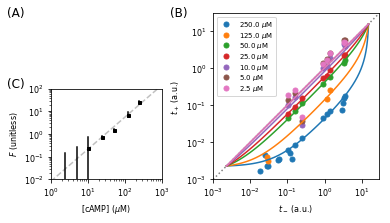

In [9]:
# Plot only occlusion data
### Figure 2: Occlusion measurements ##
fig, axs = plt.subplots(figsize=[textwidth,3])



# Set lims
lim = [1E-3,3E1]
ticks = np.logspace(-3,2)

### Subplot A: occlusion
gs = gridspec.GridSpec(1, 1, top=.95, bottom=.18, left=.50, right=.98, wspace=.2)
ax = plt.subplot(gs[0,0])

# Samples labels colors
oc0_slc = [('%.1f_oc0.*'%conc, '%.1f $\mu$M'%conc, colors[i]) for i, conc in enumerate(concs)]

# Plot data points
num_points, num_outliers = plot_manifold_measurements(ax=ax, 
                               df=new_df, 
                               samples_labels_colors=oc0_slc, 
                               markersize=markersize, 
                               fontsize=fontsize,
                               lim=lim,
                               legend_loc='upper left')
#ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=3, fontsize=7)
ax.set_aspect('equal')
ax.legend(fontsize=7, labelspacing=.1)

# Plot fit models
for i, conc in enumerate(concs):
    log_F = results_df.loc[conc,'log_F_50']
    plot_manifold_model(ax, 
                       t_sat = np.exp(log_t_sat),
                       t_bg = np.exp(log_t_bg_occ),
                       F = np.exp(log_F),
                       alpha = 0,
                       beta = 1,
                       color=colors[i])


### Plot B
gs = gridspec.GridSpec(1, 1, top=.60, bottom=.18, left=.12, right=.40, wspace=.2)
ax = plt.subplot(gs[0,0])

xlim = np.array([1E0,1E3])
ylim = np.array([1E-2,1E2])

# Grab Fs
spacing = 0.5
Fs_50 = np.exp(np.array([results_df.loc[conc,'log_F_50'] for conc in concs]))
Fs_16 = np.exp(np.array([results_df.loc[conc,'log_F_16'] for conc in concs]))
Fs_84 = np.exp(np.array([results_df.loc[conc,'log_F_84'] for conc in concs]))

log_xs = np.log(concs)
log_ys = np.log(Fs_50)
indices = [0,1,2,3,4]
   
# Fit a line to data
slope, intercept, r_value, p_value, std_err = stats.linregress(log_xs[indices],log_ys[indices])
line_log_xs = np.log(xlim)
line_log_ys = intercept + slope*line_log_xs

ax.loglog(np.exp(line_log_xs), np.exp(line_log_ys), '--', color='silver')
print('power= %.2f +- %.2f'%(slope,1.96*std_err))
    
# Plot Fs
color = 'k'
for (conc,F_16,F_84) in zip(concs, Fs_16, Fs_84):
    ax.loglog([conc, conc],[F_16, F_84], '-', color=color)
ax.loglog(concs,Fs_50,'s',color=color,markersize=3)
    
x = 1.5E0
y = 3E1
#ax.text(x,y,'$F \\propto [\\mathrm{cAMP}]^{\ %.2f \\pm %.2f}$'%(slope,1.96*std_err))
    
ax.set_ylim(ylim)
ax.set_xlim(xlim)
ax.set_xlabel('[cAMP] ($\mu$M)')
ax.set_ylabel('$F$ (unitless)')
#ax.set_aspect('equal')

# Label panels
plt.figtext(.01,.98,'(A)', fontsize=panel_label_size, horizontalalignment='left', 
            verticalalignment='top')
plt.figtext(.42,.98,'(B)', fontsize=panel_label_size, horizontalalignment='left', 
            verticalalignment='top')
plt.figtext(.01,.65,'(C)', fontsize=panel_label_size, horizontalalignment='left', 
            verticalalignment='top')

#plt.tight_layout()
fig.savefig('../figures/plt_crp_titration.pdf', transparent=True)
